In [1]:
import jax
import jax.numpy as jnp
import rerun as rr
import b3d
import matplotlib.pyplot as plt

In [2]:
def all_pairs_2(X, Y):
    return jnp.swapaxes(
        jnp.stack(jnp.meshgrid(X, Y), axis=-1),
        0, 1
    ).reshape(-1, 2)

In [ ]:
def all_pairs_2(X, Y):
    return jnp.swapaxes(
        jnp.stack(jnp.meshgrid(X, Y), axis=-1),
        0, 1
    ).reshape(-1, 2)

def get_tesselation(width, height):
    """
    Triangular teseslation with unit equliatral triangles
    with the flat side at the bottom.
    """
    width = 20
    height = 20

    h = jnp.sqrt(3) / 2
    n_layers = int(height // h + 1)

    x_pts = jnp.linspace(0, width, width + 1)
    # 2h increments
    y_pts = jnp.arange(n_layers // 2 + 1) * 2 * h
    # first index = x; second index = y
    aligned_pairs = jnp.swapaxes(jnp.stack(jnp.meshgrid(x_pts, y_pts), axis=-1), 0, 1)

    # odd rows are shifted by half a unit
    x_pts_2 = x_pts + 0.5
    y_pts_2 = y_pts + h
    shifted_pairs = jnp.swapaxes(jnp.stack(jnp.meshgrid(x_pts_2, y_pts_2), axis=-1), 0, 1)

    l = aligned_pairs.size

    # (i, 2kh) -> (i + 1, 2kh) -> (i, 2kh + h)
    def get_face_type1(ik):
        i, k = ik
        i1 = jnp.unravel_index((i, k), aligned_pairs.shape)
        i2 = jnp.unravel_index((i + 1, k), aligned_pairs.shape)
        i3 = l + jnp.unravel_index((i, k), shifted_pairs.shape)
        return jnp.array([i1, i2, i3])
    faces = jax.vmap(get_face_type1)(b3d.utils.all_pairs(width, n_layers // 2))

    # (i + 0.5, 2kh + h) -> (i + 1.5, 2kh + h) -> (i + 1, 2kh)
    def get_face_type2(ik):
        i, k = ik
        i1 = l + jnp.unravel_index((i, k), shifted_pairs.shape)
        i2 = l + jnp.unravel_index((i + 1, k), shifted_pairs.shape)
        i3 = jnp.unravel_index((i + 1, k), aligned_pairs.shape)
        return jnp.array([i1, i2, i3])
    faces = jnp.concatenate([faces, jax.vmap(get_face_type2)(b3d.utils.all_pairs(width, n_layers // 2))])

    # (i + 0.5, 2kh + h) -> (i + 1.5, 2kh + h) -> (i + 1, 2(k+1)h + h)
    def get_face_type3(ik):
        i, k = ik
        i1 = l + jnp.unravel_index((i, k), shifted_pairs.shape)
        i2 = l + jnp.unravel_index((i + 1, k), shifted_pairs.shape)
        i3 = l + jnp.unravel_index((i + 1, k + 1), shifted_pairs.shape)
        return jnp.array([i1, i2, i3])
    faces = jnp.concatenate([faces, jax.vmap(get_face_type3)(b3d.utils.all_pairs(width, n_layers // 2 - 1))])

    # (i, 2(k+1)h) -> (i + 1, 2(k+1)h) -> (i + 0.5, 2kh + h)
    def get_face_type4(ik):
        i, k = ik
        i1 = jnp.unravel_index((i, k + 1), aligned_pairs.shape)
        i2 = jnp.unravel_index((i + 1, k + 1), aligned_pairs.shape)
        i3 = l + jnp.unravel_index((i, k), shifted_pairs.shape)
        return jnp.array([i1, i2, i3])
    faces = jnp.concatenate([faces, jax.vmap(get_face_type4)(b3d.utils.all_pairs(width, n_layers // 2 - 1))])

    all_vertices = jnp.concatenate([aligned_pairs.reshape(-1, 2), shifted_pairs.reshape(-1, 2)])
    return all_vertices, faces

In [8]:
def get_tesselation(width, height):
    """
    Triangular teseslation with unit equliatral triangles
    with the flat side at the bottom.
    """
    h = jnp.sqrt(3) / 2
    n_layers = int(height // h + 1)

    x_pts = jnp.linspace(0, width, width + 1)
    # 2h increments
    y_pts = jnp.arange(n_layers // 2 + 1) * 2 * h
    # first index = x; second index = y
    aligned_pairs = jnp.swapaxes(jnp.stack(jnp.meshgrid(x_pts, y_pts), axis=-1), 0, 1)

    # odd rows are shifted by half a unit
    x_pts_2 = x_pts + 0.5
    y_pts_2 = y_pts + h
    shifted_pairs = jnp.swapaxes(jnp.stack(jnp.meshgrid(x_pts_2, y_pts_2), axis=-1), 0, 1)

    l = aligned_pairs.size

    # (i, 2kh) -> (i + 1, 2kh) -> (i, 2kh + h)
    def get_face_type1(ik):
        i, k = ik
        i1 = jnp.unravel_index(jnp.array([i, k]), aligned_pairs.shape)
        i2 = jnp.unravel_index(jnp.array([i + 1, k]), aligned_pairs.shape)
        i3 = l + jnp.unravel_index(jnp.array([i, k]), shifted_pairs.shape)
        return jnp.array([i1, i2, i3])
    faces = jax.vmap(get_face_type1)(b3d.utils.all_pairs(width, n_layers // 2))

    # # (i + 0.5, 2kh + h) -> (i + 1.5, 2kh + h) -> (i + 1, 2kh)
    # def get_face_type2(ik):
    #     i, k = ik
    #     i1 = l + jnp.unravel_index(jnp.array([i, k]), shifted_pairs.shape)
    #     i2 = l + jnp.unravel_index(jnp.array([i + 1, k]), shifted_pairs.shape)
    #     i3 = jnp.unravel_index(jnp.array([i + 1, k]), aligned_pairs.shape)
    #     return jnp.array([i1, i2, i3])
    # faces = jnp.concatenate([faces, jax.vmap(get_face_type2)(b3d.utils.all_pairs(width, n_layers // 2))])

    # # (i + 0.5, 2kh + h) -> (i + 1.5, 2kh + h) -> (i + 1, 2(k+1)h + h)
    # def get_face_type3(ik):
    #     i, k = ik
    #     i1 = l + jnp.unravel_index(jnp.array([i, k]), shifted_pairs.shape)
    #     i2 = l + jnp.unravel_index(jnp.array([i + 1, k]), shifted_pairs.shape)
    #     i3 = l + jnp.unravel_index(jnp.array([i + 1, k + 1]), shifted_pairs.shape)
    #     return jnp.array([i1, i2, i3])
    # faces = jnp.concatenate([faces, jax.vmap(get_face_type3)(b3d.utils.all_pairs(width, n_layers // 2 - 1))])

    # # (i, 2(k+1)h) -> (i + 1, 2(k+1)h) -> (i + 0.5, 2kh + h)
    # def get_face_type4(ik):
    #     i, k = ik
    #     i1 = jnp.unravel_index(jnp.array([i, k + 1]), aligned_pairs.shape)
    #     i2 = jnp.unravel_index(jnp.array([i + 1, k + 1]), aligned_pairs.shape)
    #     i3 = l + jnp.unravel_index(jnp.array([i, k]), shifted_pairs.shape)
    #     return jnp.array([i1, i2, i3])
    # faces = jnp.concatenate([faces, jax.vmap(get_face_type4)(b3d.utils.all_pairs(width, n_layers // 2 - 1))])

    all_vertices = jnp.concatenate([aligned_pairs.reshape(-1, 2), shifted_pairs.reshape(-1, 2)])
    return all_vertices, faces

In [9]:
all_vertices, faces = get_tesselation(20, 20)

TypeError: unsupported operand type(s) for +: 'int' and 'tuple'

In [12]:
width = 20
height = 20

h = jnp.sqrt(3) / 2
n_layers = int(height // h + 1)

x_pts = jnp.linspace(0, width, width + 1)
# 2h increments
y_pts = jnp.arange(n_layers // 2 + 1) * 2 * h
# first index = x; second index = y
aligned_pairs = jnp.swapaxes(jnp.stack(jnp.meshgrid(x_pts, y_pts), axis=-1), 0, 1)

# odd rows are shifted by half a unit
x_pts_2 = x_pts + 0.5
y_pts_2 = y_pts + h
shifted_pairs = jnp.swapaxes(jnp.stack(jnp.meshgrid(x_pts_2, y_pts_2), axis=-1), 0, 1)

l = aligned_pairs.size

In [27]:
# (i, 2kh) -> (i + 1, 2kh) -> (i, 2kh + h)
def get_face_type1(ik):
    i, k = ik
    i1 = jnp.ravel_multi_index((i, k), aligned_pairs.shape[:2])
    i2 = jnp.ravel_multi_index((i + 1, k), aligned_pairs[:2])
    i3 = l + jnp.ravel_multi_index((i, k), shifted_pairs[:2])
    return jnp.array([i1, i2, i3])


In [28]:
b3d.utils.all_pairs(width, n_layers // 2).shape

(240, 2)

In [29]:
faces = jax.vmap(get_face_type1, in_axes=(0,))(b3d.utils.all_pairs(width, n_layers // 2))

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int32[].
The error occurred because ravel_multi_index was jit-compiled with mode='raise'. Use mode='wrap' or mode='clip' instead.
This BatchTracer with object id 140667637849664 was created on line:
  /var/tmp/ipykernel_16873/3488627673.py:3 (get_face_type1)

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [17]:
l

546

In [26]:
jnp.ravel_multi_index((1, 1), aligned_pairs.shape[:2])

Array(14, dtype=int32)

In [24]:
aligned_pairs.shape

(21, 13, 2)

In [45]:
def _tessellate(width, height):
    num_points_x = width + 1
    num_points_y = int(height / (jnp.sqrt(3) / 2)) + 1

    # Generate the x and y coordinates for all points
    x_coords = jnp.arange(num_points_x)
    y_coords = jnp.arange(num_points_y) * (jnp.sqrt(3) / 2)
    
    # Create a grid of x and y coordinates
    x_grid, y_grid = jnp.meshgrid(x_coords, y_coords)
    
    # Apply offset to every other row
    offsets = jnp.arange(num_points_y) % 2 * 0.5
    x_grid = x_grid + offsets[:, None]
    
    # Flatten the grid to get the vertices
    vertices = jnp.vstack((x_grid.ravel(), y_grid.ravel())).T

    # Generate the faces
    def generate_faces(y):
        p0 = y * num_points_x + jnp.arange(num_points_x - 1)
        p1 = p0 + 1
        p2 = p0 + num_points_x
        p3 = p2 + 1
        
        even_row_faces = jnp.stack([p0, p2, p1], axis=-1)
        even_row_faces = jnp.concatenate([even_row_faces, jnp.stack([p1[:-1], p2[:-1], p3[:-1]], axis=-1)], axis=0)
        
        odd_row_faces = jnp.stack([p0, p3, p1], axis=-1)
        odd_row_faces = jnp.concatenate([odd_row_faces, jnp.stack([p0[1:], p2[1:], p3[1:]], axis=-1)], axis=0)
        
        return jax.lax.cond(y % 2 == 0, lambda _: even_row_faces, lambda _: odd_row_faces, None)
    
    faces = jax.vmap(generate_faces)(jnp.arange(num_points_y - 1))
    faces = faces.reshape(-1, 3)

    return vertices, faces

def tessellate(width, height):
    v, f = _tessellate(width + 2, height)
    v = v - 1
    return v, f

In [48]:
import jax
import jax.numpy as jnp

def tessellate(width, height):
    num_points_x = width + 3  # Extend by one column on either side
    num_points_y = int(height / (jnp.sqrt(3) / 2)) + 1

    # Generate the x and y coordinates for all points
    x_coords = jnp.arange(num_points_x) - 1  # Shift x coordinates to extend on either side
    y_coords = jnp.arange(num_points_y) * (jnp.sqrt(3) / 2)
    
    # Create a grid of x and y coordinates
    x_grid, y_grid = jnp.meshgrid(x_coords, y_coords)
    
    # Apply offset to every other row
    offsets = jnp.arange(num_points_y) % 2 * 0.5
    x_grid = x_grid + offsets[:, None]
    
    # Flatten the grid to get the vertices
    vertices = jnp.vstack((x_grid.ravel(), y_grid.ravel())).T

    # Generate the faces
    def generate_faces(y):
        p0 = y * num_points_x + jnp.arange(num_points_x - 1)
        p1 = p0 + 1
        p2 = p0 + num_points_x
        p3 = p2 + 1
        
        even_row_faces = jnp.stack([p0, p2, p1], axis=-1)
        even_row_faces = jnp.concatenate([even_row_faces, jnp.stack([p1[:-1], p2[:-1], p3[:-1]], axis=-1)], axis=0)
        
        odd_row_faces = jnp.stack([p0, p3, p1], axis=-1)
        odd_row_faces = jnp.concatenate([odd_row_faces, jnp.stack([p0[1:], p2[1:], p3[1:]], axis=-1)], axis=0)
        
        return jax.lax.cond(y % 2 == 0, lambda _: even_row_faces, lambda _: odd_row_faces, None)
    
    faces = jax.vmap(generate_faces)(jnp.arange(num_points_y - 1))
    faces = faces.reshape(-1, 3)

    return vertices, faces

# Example usage
width = 10
height = 10
vertices, faces = tessellate(width, height)
print("Vertices:\n", vertices)
print("Faces:\n", faces)


Vertices:
 [[-1.         0.       ]
 [ 0.         0.       ]
 [ 1.         0.       ]
 [ 2.         0.       ]
 [ 3.         0.       ]
 [ 4.         0.       ]
 [ 5.         0.       ]
 [ 6.         0.       ]
 [ 7.         0.       ]
 [ 8.         0.       ]
 [ 9.         0.       ]
 [10.         0.       ]
 [11.         0.       ]
 [-0.5        0.8660254]
 [ 0.5        0.8660254]
 [ 1.5        0.8660254]
 [ 2.5        0.8660254]
 [ 3.5        0.8660254]
 [ 4.5        0.8660254]
 [ 5.5        0.8660254]
 [ 6.5        0.8660254]
 [ 7.5        0.8660254]
 [ 8.5        0.8660254]
 [ 9.5        0.8660254]
 [10.5        0.8660254]
 [11.5        0.8660254]
 [-1.         1.7320508]
 [ 0.         1.7320508]
 [ 1.         1.7320508]
 [ 2.         1.7320508]
 [ 3.         1.7320508]
 [ 4.         1.7320508]
 [ 5.         1.7320508]
 [ 6.         1.7320508]
 [ 7.         1.7320508]
 [ 8.         1.7320508]
 [ 9.         1.7320508]
 [10.         1.7320508]
 [11.         1.7320508]
 [-0.5        

In [49]:
v, f = tessellate(10, 10)

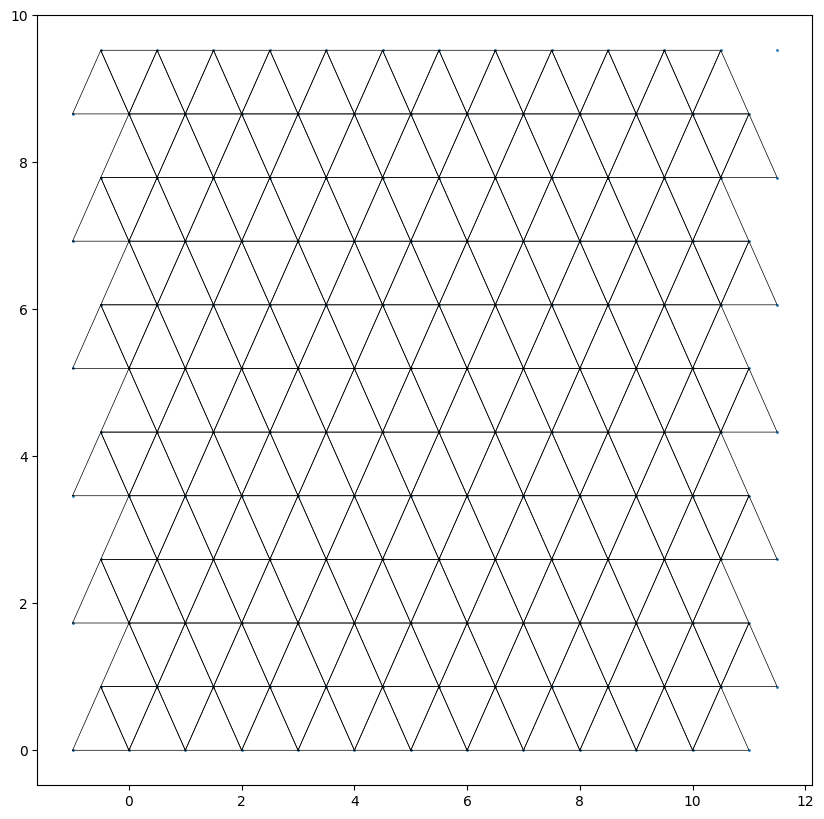

In [50]:
plt.figure(figsize=(10, 10))

# plot all the points (x, y) in v
plt.scatter(v[:, 0], v[:, 1], s=1)

# plot all the lines v[f[i]] -> v[f[i, 1]] for all i
for i in range(f.shape[0]):
    plt.plot(v[f[i, [0, 1, 2, 0]], 0], v[f[i, [0, 1, 2, 0]], 1], 'k-', lw=0.5)

In [ ]:
def triangle2D_to_gridsquare_overlap_areas(triangle, max_steps_x, max_steps_y):
    """
    For every grid square with integral vertices that intersects `triangle`,
    compute the area of the overlap between the square and the triangle.
    By a "grid square with integral vertices", I mean a square on the 2D plane
    with bottom left corner at (i, j) and top right corner at (i+1, j+1),

    Args:
   - triangle: [v1, v2, v3], where each v is a (2,) array
   - max_steps_x, max_steps_y : integers

    Returns:
    - square_indices: a (max_step_x * max_step_y, 2) array of (i, j) pairs, giving
        the bottom left corner of a square.
    - areas: the area of the overlap between the triangle and the square.
   """
    # Bounding box for the triangle
    min_x = jnp.floor(jnp.min(triangle[:, 0])).astype(int)
    min_y = jnp.floor(jnp.min(triangle[:, 1])).astype(int)

    x_coords = min_x + jnp.arange(0, max_steps_x)
    y_coords = min_y + jnp.arange(0, max_steps_y)
    bottom_left_corners = all_pairs_2(x_coords, y_coords).T
    areas = jax.vmap(lambda blc: compute_overlap_area(triangle, blc))(bottom_left_corners)
    
    return bottom_left_corners, areas

def line_intersection(p1, p2, q1, q2):
    """
    Compute the intersection point of two lines (p1-p2 and q1-q2).
    """
    s1 = p2 - p1
    s2 = q2 - q1
    denom = (-s2[0] * s1[1] + s1[0] * s2[1])
    s = (-s1[1] * (p1[0] - q1[0]) + s1[0] * (p1[1] - q1[1])) / denom
    t = ( s2[0] * (p1[1] - q1[1]) - s2[1] * (p1[0] - q1[0])) / denom
    intersection = p1 + (t * s1)
    return jnp.where((s >= 0) & (s <= 1) & (t >= 0) & (t <= 1), intersection, jnp.array([-10000, -10000]))

def point_in_triangle(p, triangle):
    """
    Check if a point is inside a triangle.
    """
    def sign(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])
    b1 = sign(p, triangle[0], triangle[1]) < 0.0
    b2 = sign(p, triangle[1], triangle[2]) < 0.0
    b3 = sign(p, triangle[2], triangle[0]) < 0.0
    return (b1 == b2) & (b2 == b3)

def convex_hull_area(points):
    """
    Calculate the area of a polygon given its vertices using the convex hull.
    """
    if points.shape[0] < 3:
        return 0.0

    points = points[~jnp.all(points == -10000, axis=1)]  # Remove invalid points
    points = points[jnp.lexsort((points[:,1], points[:,0]))]  # Sort points lexicographically

    def cross(o, a, b):
        return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])

    lower = []
    for p in points:
        while len(lower) >= 2 and cross(lower[-2], lower[-1], p) <= 0:
            lower.pop()
        lower.append(p)

    upper = []
    for p in points[::-1]:
        while len(upper) >= 2 and cross(upper[-2], upper[-1], p) <= 0:
            upper.pop()
        upper.append(p)

    hull = jnp.array(lower[:-1] + upper[:-1])

    return 0.5 * jnp.abs(jnp.dot(hull[:,0], jnp.roll(hull[:,1], 1)) - jnp.dot(hull[:,1], jnp.roll(hull[:,0], 1)))

def compute_area_of_triangle_square_intersection(triangle, square):
    """
    Calculate the area of intersection between a triangle and a square.
    `square` is given as a (2,) array with the bottom left corner.
    """
    square_vertices = jnp.array([
        square,
        square + jnp.array([1, 0]),
        square + jnp.array([1, 1]),
        square + jnp.array([0, 1])
    ])

    intersection_points = []
    for i in range(3):
        for j in range(4):
            intersection_points.append(line_intersection(triangle[i], triangle[(i+1)%3], square_vertices[j], square_vertices[(j+1)%4]))

    intersection_points = jnp.array(intersection_points)
    intersection_points = jnp.vstack((intersection_points, square_vertices[jnp.all(jnp.array([point_in_triangle(p, triangle) for p in square_vertices]), axis=1)]))
    intersection_points = jnp.vstack((intersection_points, triangle[jnp.all(jnp.array([point_in_triangle(p, square_vertices) for p in triangle]), axis=1)]))

    return convex_hull_area(intersection_points)

